In this notebook we summarize the results.

In [12]:
import sys
sys.path.append("..")
import mlflow
import pandas as pd
import dotenv
import os
from mlflow.tracking import MlflowClient
from eda_utils.plots import plot_side_by_side 
dotenv.load_dotenv("../.env",override=True)

True

### Query the metrics from mlflow

In [13]:
uri = os.environ["MLFLOW_TRACKING_URI"]
mlflow.set_tracking_uri(uri)

In [14]:
experiment_name = "zero-shot-few-shot-prompting"
client = MlflowClient()
experiment = client.get_experiment_by_name(experiment_name)

In [209]:
runs = mlflow.search_runs(
    experiment_ids=[experiment.experiment_id],
    filter_string="",  # Optional: Add filters here if needed
    run_view_type=mlflow.entities.ViewType.ACTIVE_ONLY,
)

In [210]:
runs = runs.astype({column: float for column in runs.columns if "metric" in column or ("params" in column and column!="params.model_name")})

In [211]:
runs.columns

Index(['run_id', 'experiment_id', 'status', 'artifact_uri', 'start_time',
       'end_time', 'metrics.hallucination_rate', 'metrics.accuracy_score',
       'metrics.median_response_token_count', 'metrics.precision',
       'metrics.false_negative_rate', 'metrics.false_positive_rate',
       'metrics.bad_output_format_rate', 'metrics.median_query_token_count',
       'metrics.median_processing_time', 'metrics.recall',
       'metrics.median_tokens_per_second', 'params.top_p', 'params.top_k',
       'params.temperature', 'params.model_name', 'tags.mlflow.source.type',
       'tags.justification', 'tags.mlflow.user', 'tags.mlflow.runName',
       'tags.mlflow.source.name'],
      dtype='object')

In [212]:
default_parameter_mask = ((runs["params.temperature"]==0.2) & (runs["params.top_p"]==0.95) & (runs["params.top_k"]==40))
full_dataset_mask = runs["tags.mlflow.runName"].str.contains("FULL_DATA")
initial_gridsearch_mask = runs["tags.mlflow.runName"].str.contains("t\d")

In [213]:
grid_search_experiment_runs = runs[initial_gridsearch_mask]

In [214]:
non_grid_search_experiment_runs = runs[ ~ initial_gridsearch_mask& ~ full_dataset_mask & default_parameter_mask]

Make sure that there is an experiment run with each model size for each prompt.

In [21]:
assert non_grid_search_experiment_runs.groupby(["tags.mlflow.runName", "params.model_name"]).size().sum() == len(non_grid_search_experiment_runs)

### Visualizations

#### Classification performance

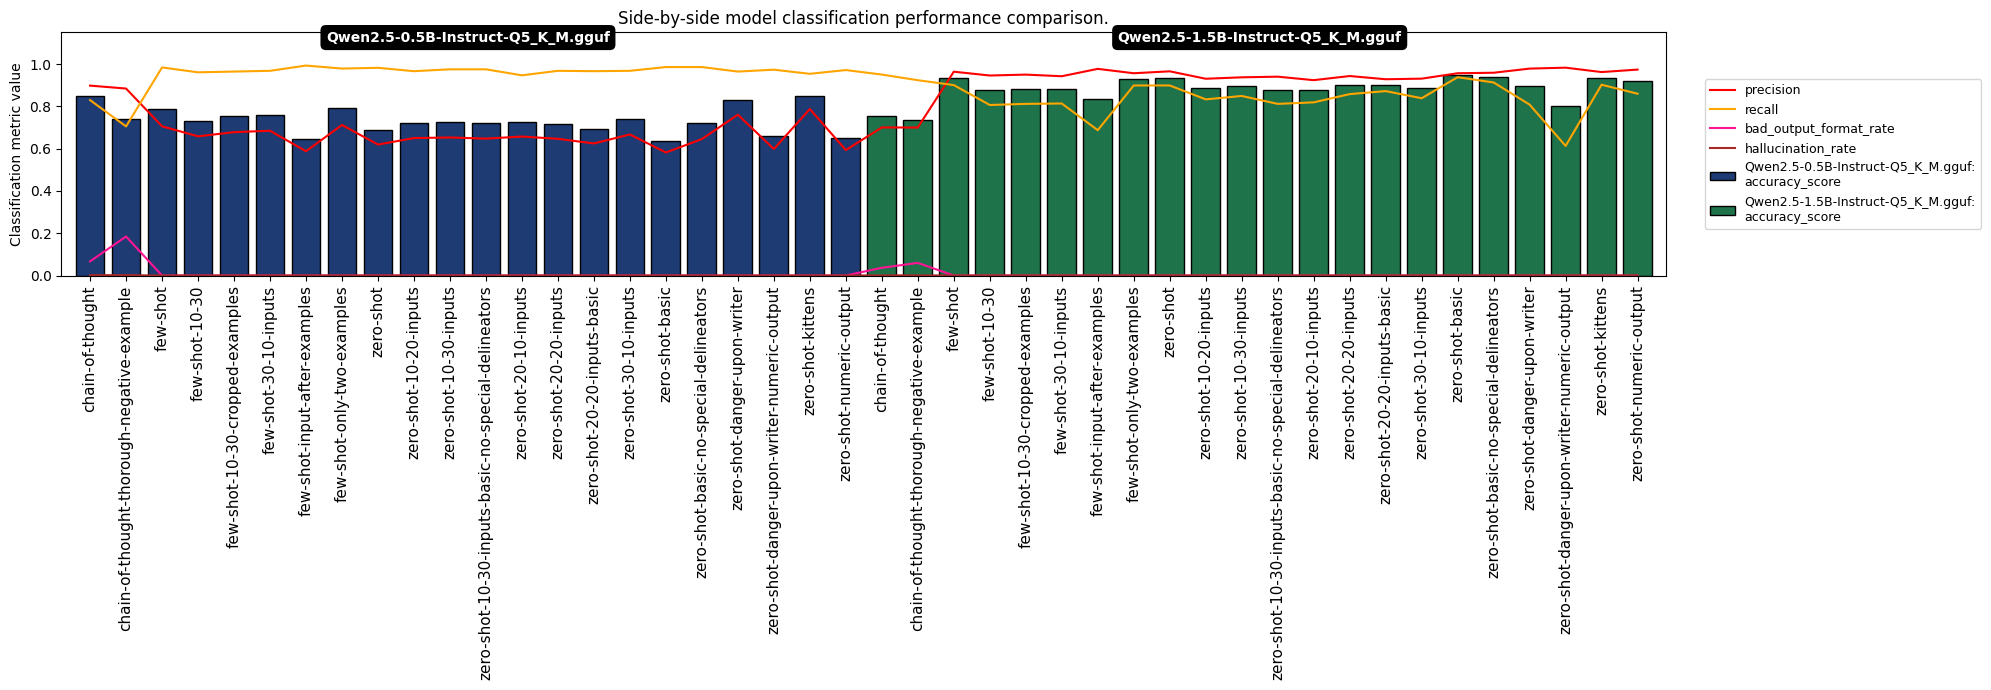

In [24]:
plot_side_by_side(
    non_grid_search_experiment_runs,
    separation_criterion_column="params.model_name",
    result_grouping_label_column="tags.mlflow.runName",
    line_plot_columns=[
        "metrics.precision",
        "metrics.recall",
        "metrics.bad_output_format_rate",
        "metrics.hallucination_rate",
    ],
    bar_plot_columns=[
        "metrics.accuracy_score",
    ],
    groups_bar_color_palette={
        "Qwen2.5-0.5B-Instruct-Q5_K_M.gguf": {
            "metrics.accuracy_score": "#1f3b73",  # dark blue
        },
        "Qwen2.5-1.5B-Instruct-Q5_K_M.gguf": {
            "metrics.accuracy_score": "#1f734a",  # dark green
        },
    },
    line_plot_colors=["red", "orange", "#FF1493", "#A52A2A"],
    # order="abab",
    output_file="../figs/side_by_side_comparison.png",
)

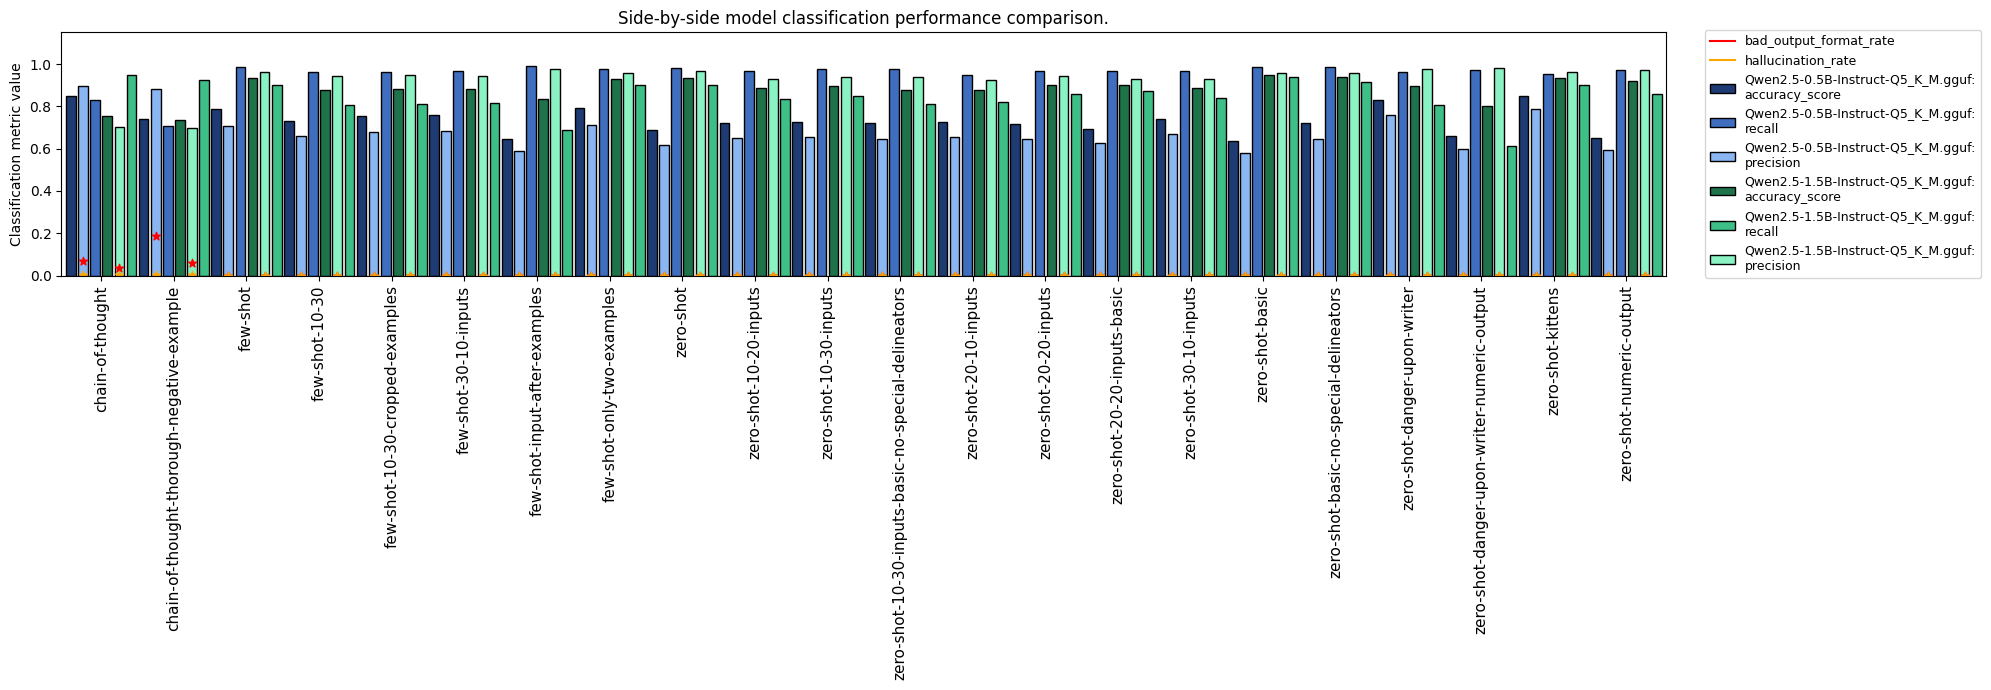

In [22]:
plot_side_by_side(
    non_grid_search_experiment_runs,
    separation_criterion_column="params.model_name",
    result_grouping_label_column="tags.mlflow.runName",
    line_plot_columns=[
        "metrics.bad_output_format_rate",
        "metrics.hallucination_rate",
    ],
    bar_plot_columns=[
        "metrics.accuracy_score",
        "metrics.precision",
        "metrics.recall",
    ],
    groups_bar_color_palette={
        "Qwen2.5-0.5B-Instruct-Q5_K_M.gguf": {
            "metrics.accuracy_score": "#1f3b73", 
            "metrics.recall": "#3f6ebf",  
            "metrics.precision": "#8ab6f2",  
        },
        "Qwen2.5-1.5B-Instruct-Q5_K_M.gguf": {
            "metrics.accuracy_score": "#1f734a",  
            "metrics.recall": "#3fbf88",  
            "metrics.precision": "#8af2c3",  
        },
    },
    line_plot_colors=["red", "orange", "#FF1493", "#A52A2A"],
    order="abab",
    output_file="../figs/alternating_comparison.png",
)

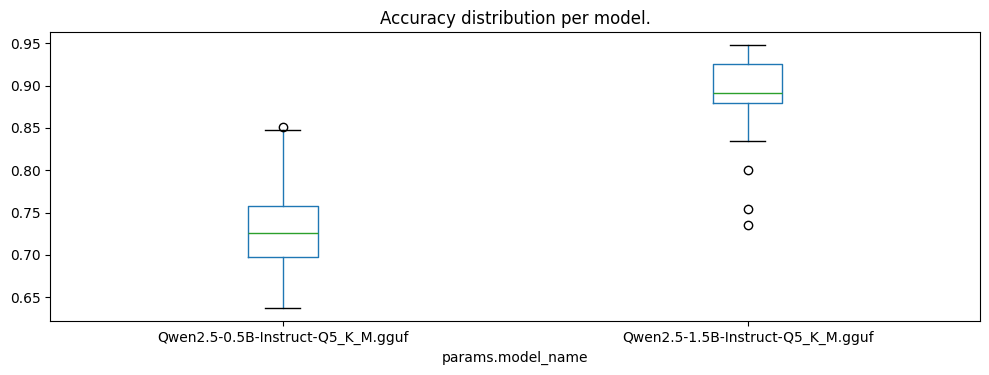

In [48]:
ax = non_grid_search_experiment_runs.boxplot(by="params.model_name", column="metrics.accuracy_score", grid=False, figsize=(10,4),)
ax.set_title("Accuracy distribution per model.")
fig = ax.get_figure()
fig.suptitle('')
plt.tight_layout()

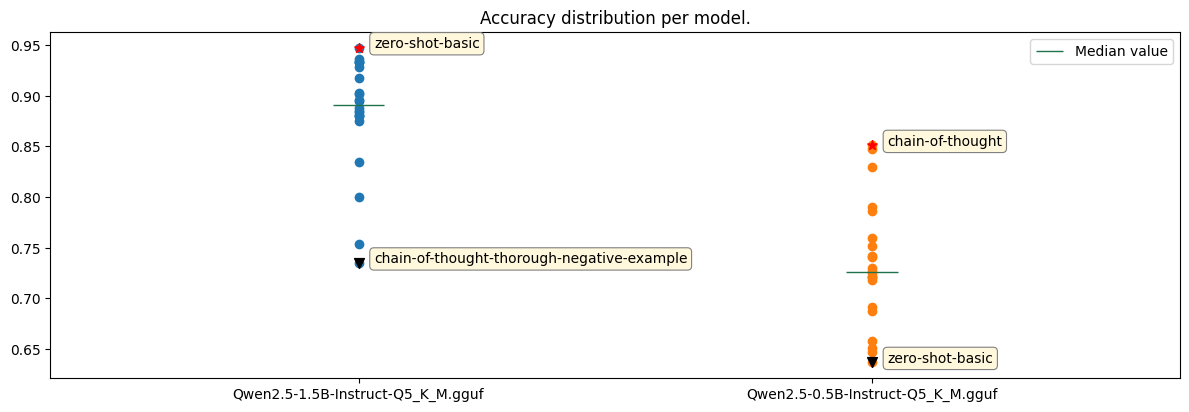

In [123]:
plt.figure(figsize = (12, 4))
for i, model in enumerate(non_grid_search_experiment_runs["params.model_name"].unique()):
    values = non_grid_search_experiment_runs["metrics.accuracy_score"][non_grid_search_experiment_runs["params.model_name"]==model]
    argmax = values.argmax()
    argmin = values.argmin()
    plt.scatter(non_grid_search_experiment_runs["params.model_name"][non_grid_search_experiment_runs["params.model_name"]==model], 
            values,
                )
    plt.scatter(model, 
                values.iloc[argmax],
                marker="*", c="r", s = 50)
    plt.scatter(model, 
                values.iloc[argmin],
                marker="v", c="black", s = 50)
    plt.text(i+0.03, 
             values.iloc[argmax],
             s = non_grid_search_experiment_runs['tags.mlflow.runName'][non_grid_search_experiment_runs["params.model_name"]==model].iloc[argmax],
             bbox=dict(boxstyle="round,pad=0.3", facecolor="#fff8dc", edgecolor="gray", linewidth=0.8),
             
            )
    plt.text(i+0.03, 
             values.iloc[argmin],
             s = non_grid_search_experiment_runs['tags.mlflow.runName'][non_grid_search_experiment_runs["params.model_name"]==model].iloc[argmin],
             bbox=dict(boxstyle="round,pad=0.3", facecolor="#fff8dc", edgecolor="gray", linewidth=0.8),
             
            )
    median_val = values.median()
    plt.hlines(
        y=[values.quantile(0.5)],
        xmin=i - 0.05,
        xmax=i + 0.05,
        colors="#1f734a",
        linestyles="solid",
        linewidth=1,
        label=f"Median value" if i == 0 else None  
    )
    plt.xlim(-0.6, 1.6)
plt.legend(bbox_to_anchor=(1, 1))
plt.tight_layout()
_ = plt.title("Accuracy distribution per model.")
plt.savefig("../figs/accuracy_distribution_per_model.png")

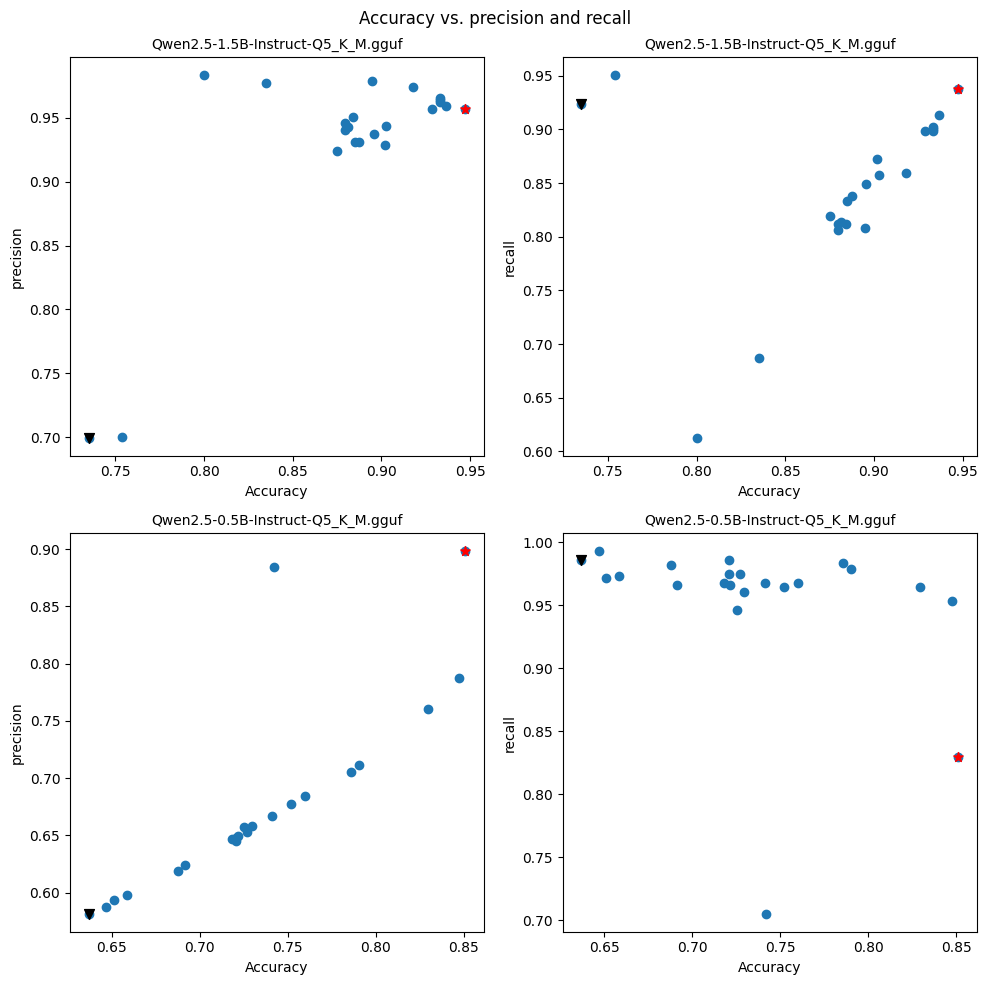

In [147]:
fig = plt.figure(figsize=(10,10))
ax = fig.subplots(2,2)
for i, model in enumerate(non_grid_search_experiment_runs["params.model_name"].unique()):
    model_df = non_grid_search_experiment_runs[non_grid_search_experiment_runs["params.model_name"]==model]
    accuracy = model_df["metrics.accuracy_score"]
    argmax = accuracy.argmax()
    argmin = accuracy.argmin()
    for j, metric in enumerate(["metrics.precision", "metrics.recall"]):
        ax[i][j].scatter(accuracy, model_df[metric])
        ax[i][j].set_title(f"{model}", fontsize = 10)
        ax[i][j].set_ylabel(metric.replace("metrics.",""))
        ax[i][j].set_xlabel("Accuracy")
        ax[i][j].scatter(accuracy.iloc[argmax], 
                model_df[metric].iloc[argmax],
                marker="*", c="r", s = 50)
        ax[i][j].scatter(accuracy.iloc[argmin], 
                model_df[metric].iloc[argmin],
                marker="v", c="black", s = 50)
plt.suptitle("Accuracy vs. precision and recall")
plt.tight_layout()

plt.savefig("../figs/accuracy_vs_precision_and_recall.png")

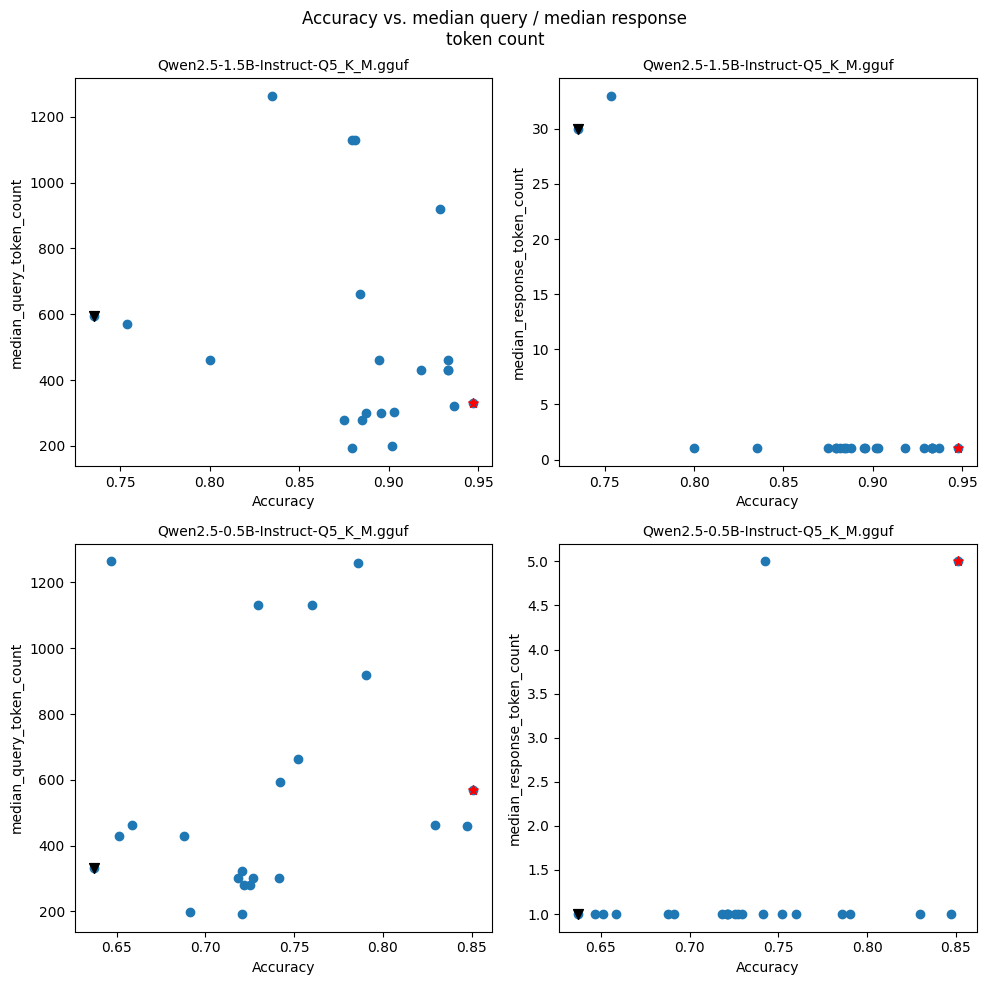

In [156]:
fig = plt.figure(figsize=(10,10))
ax = fig.subplots(2,2)
for i, model in enumerate(non_grid_search_experiment_runs["params.model_name"].unique()):
    model_df = non_grid_search_experiment_runs[non_grid_search_experiment_runs["params.model_name"]==model]
    accuracy = model_df["metrics.accuracy_score"]
    argmax = accuracy.argmax()
    argmin = accuracy.argmin()
    for j, metric in enumerate(["metrics.median_query_token_count", "metrics.median_response_token_count"]):
        ax[i][j].scatter(accuracy, model_df[metric])
        ax[i][j].set_title(f"{model}", fontsize = 10)
        ax[i][j].set_ylabel(metric.replace("metrics.",""))
        ax[i][j].set_xlabel("Accuracy")
        ax[i][j].scatter(accuracy.iloc[argmax], 
                model_df[metric].iloc[argmax],
                marker="*", c="r", s = 50)
        ax[i][j].scatter(accuracy.iloc[argmin], 
                model_df[metric].iloc[argmin],
                marker="v", c="black", s = 50)
plt.suptitle("Accuracy vs. median query / median response\ntoken count")
plt.tight_layout()
plt.savefig("../figs/accuracy_vs_token_counts.png")

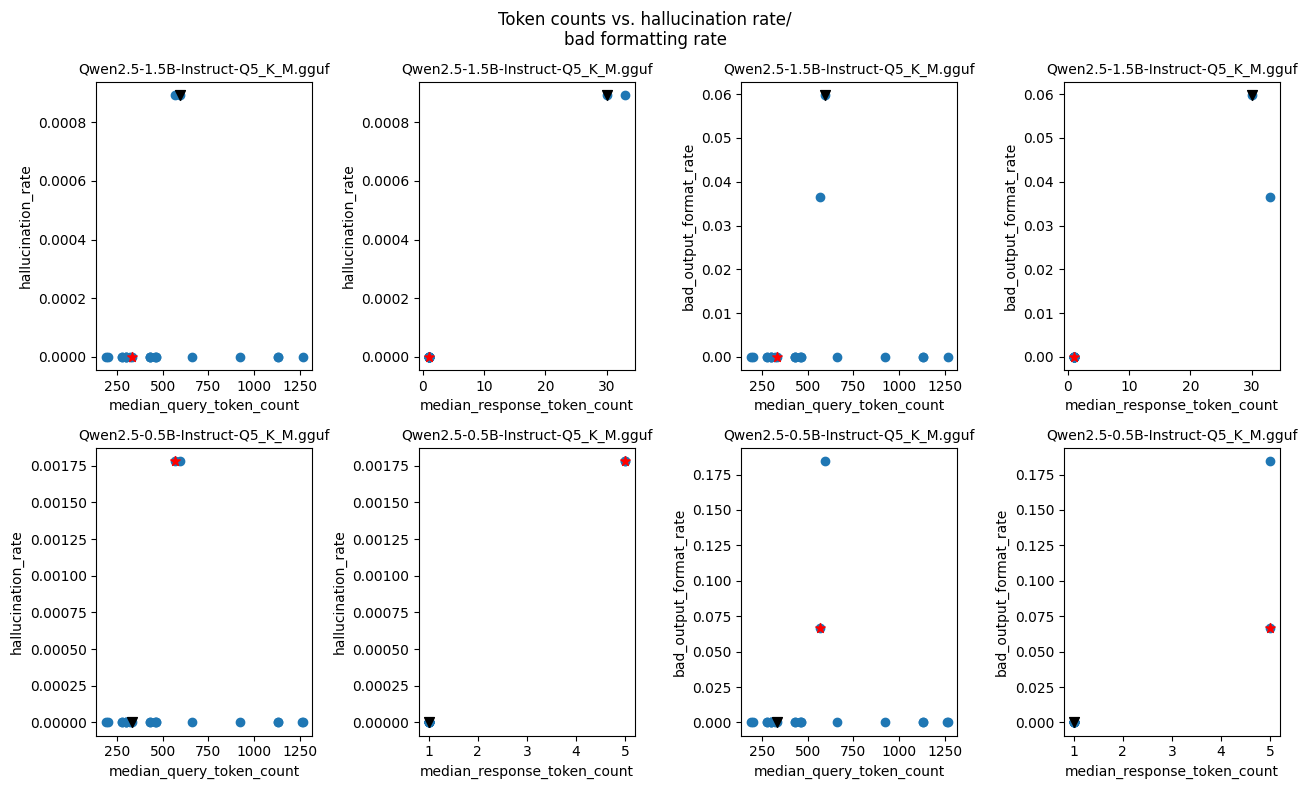

In [179]:
fig = plt.figure(figsize=(13,8))
ax = fig.subplots(2,4)

for i, model in enumerate(non_grid_search_experiment_runs["params.model_name"].unique()):
    model_df = non_grid_search_experiment_runs[non_grid_search_experiment_runs["params.model_name"]==model]
    accuracy = model_df["metrics.accuracy_score"]
    argmax = accuracy.argmax()
    argmin = accuracy.argmin()
    c = 0
    for j, metric in enumerate(["metrics.hallucination_rate", "metrics.bad_output_format_rate"]):
        ax[i][j+c].scatter(model_df["metrics.median_query_token_count"], model_df[metric])
        ax[i][j+c].set_title(f"{model}", fontsize = 10)
        ax[i][j+c].set_ylabel(metric.replace("metrics.",""))
        ax[i][j+c].set_xlabel("median_query_token_count")
        ax[i][j+c].scatter(model_df["metrics.median_query_token_count"].iloc[argmax], 
                model_df[metric].iloc[argmax],
                marker="*", c="r", s = 50, label = "best accuracy")
        ax[i][j+c].scatter(model_df["metrics.median_query_token_count"].iloc[argmin], 
                model_df[metric].iloc[argmin],
                marker="v", c="black", s = 50, label = "worst accuracy")
        
        ax[i][j+c+1].scatter(model_df["metrics.median_response_token_count"], model_df[metric])
        ax[i][j+c+1].set_title(f"{model}", fontsize = 10)
        ax[i][j+c+1].set_ylabel(metric.replace("metrics.",""))
        ax[i][j+c+1].set_xlabel("median_response_token_count")
        ax[i][j+c+1].scatter(model_df["metrics.median_response_token_count"].iloc[argmax], 
                model_df[metric].iloc[argmax],
                marker="*", c="r", s = 50, label = "best accuracy")
        ax[i][j+c+1].scatter(model_df["metrics.median_response_token_count"].iloc[argmin], 
                model_df[metric].iloc[argmin],
                marker="v", c="black", s = 50, label = "worst accuracy")
        c=1
plt.suptitle("Token counts vs. hallucination rate/\nbad formatting rate")
plt.tight_layout()
plt.savefig("../figs/toke_counts_vs_hallucination_and_bad_formatting.png")

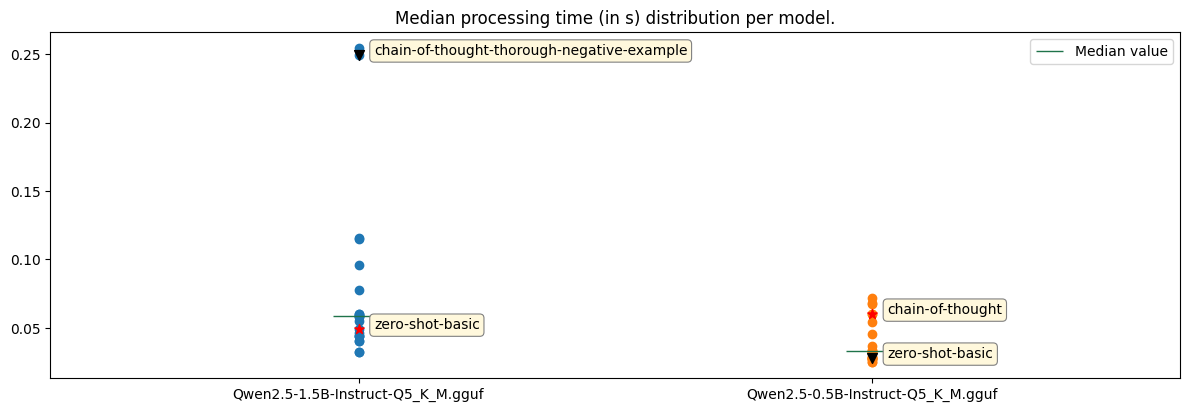

In [188]:
plt.figure(figsize = (12, 4))
for i, model in enumerate(non_grid_search_experiment_runs["params.model_name"].unique()):
    model_df = non_grid_search_experiment_runs[non_grid_search_experiment_runs["params.model_name"]==model]
    values = model_df["metrics.median_processing_time"]
    argmax = model_df["metrics.accuracy_score"].argmax()
    argmin = model_df["metrics.accuracy_score"].argmin()
    plt.scatter(non_grid_search_experiment_runs["params.model_name"][non_grid_search_experiment_runs["params.model_name"]==model], 
            values,
                )
    plt.scatter(model, 
                values.iloc[argmax],
                marker="*", c="r", s = 50)
    plt.scatter(model, 
                values.iloc[argmin],
                marker="v", c="black", s = 50)
    plt.text(i+0.03, 
             values.iloc[argmax],
             s = non_grid_search_experiment_runs['tags.mlflow.runName'][non_grid_search_experiment_runs["params.model_name"]==model].iloc[argmax],
             bbox=dict(boxstyle="round,pad=0.3", facecolor="#fff8dc", edgecolor="gray", linewidth=0.8),
             
            )
    plt.text(i+0.03, 
             values.iloc[argmin],
             s = non_grid_search_experiment_runs['tags.mlflow.runName'][non_grid_search_experiment_runs["params.model_name"]==model].iloc[argmin],
             bbox=dict(boxstyle="round,pad=0.3", facecolor="#fff8dc", edgecolor="gray", linewidth=0.8),
             
            )
    median_val = values.median()
    plt.hlines(
        y=[values.quantile(0.5)],
        xmin=i - 0.05,
        xmax=i + 0.05,
        colors="#1f734a",
        linestyles="solid",
        linewidth=1,
        label=f"Median value" if i == 0 else None  
    )
    plt.xlim(-0.6, 1.6)
plt.legend(bbox_to_anchor=(1, 1))
plt.tight_layout()
_ = plt.title("Median processing time (in s) distribution per model.")
plt.savefig("../figs/median_processing_time_distribution_per_model.png")

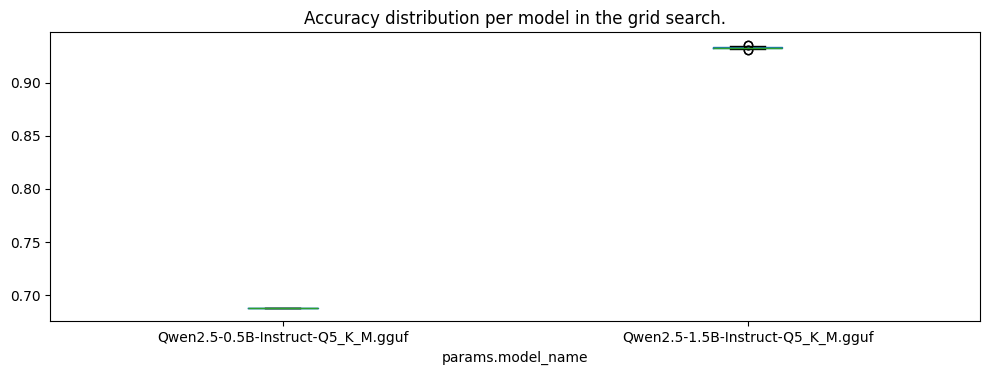

In [217]:
ax = runs[initial_gridsearch_mask].boxplot(by="params.model_name", column="metrics.accuracy_score", grid=False, figsize=(10,4),)
ax.set_title("Accuracy distribution per model in the grid search.")
fig = ax.get_figure()
fig.suptitle('')
plt.tight_layout()
plt.savefig("../figs/grid_search_distributions.png")

In [208]:
runs['metrics.median_query_token_count'].max()

np.float64(1264.0)